# Histograms

#### The goal of this notebook is to produce histograms to visualize the outputs of the ensembles for our empirical analysis. The ensembles were generated were intentionally biased with respect to some selected partisan metrics for evaluating the fairness of a districting plan--efficiency gap, mean-median, partisan gini, partisan bias, and mean-thirdian. 

In [180]:
## from load_biased_chain_run_hp.py script (see https://github.com/hamiltonw/MRC_redistricting)

import pickle
from functools import partial
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt 
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        updaters, constraints, Election, accept)
from gerrychain.proposals import recom, propose_random_flip
import hypothesis_test as hp
from settings import party_to_favor, election_name, bias_measure
import utils



In [181]:
from gerrychain.updaters.tally import DataTally
import gerrychain.metrics.partisan as pm

In [182]:
## will use this election as an updater

election = Election(
    "2016 Presidential",
    {"Democratic": "T16PRES_D", "Republican": "T16PRES_R"},
    alias="2016_PRES"
)

In [183]:
pa_vtds = gpd.read_file("./data/PA/PA.shp")
graph = Graph.from_geodataframe(pa_vtds)
del pa_vtds
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"), "2016_PRES":election} ## manually added election data for 2016 to test Election Object
my_updaters.update(utils.get_elections(party_to_favor, election_name))
initial_partition = GeographicPartition(graph, assignment="CD_2011", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i


[('PRES16', ['Republican', 'Democratic'])]


#### Next we load some previously saved biased chains and store their partitions which represent districting plans that are heavily biased towards a particular party with respect to the partisan metrics mentioned above..

In [232]:
## load biased chain

with open('/Users/edmonds.110/MRC/MRC_redistricting/chains/PRES16_Republican_efficiency_gap_10000.pkl', 'rb') as f:
    all_assignments_PRES16R = pickle.load(f)

In [234]:
## makes a test partition, in this case is the last partition in the chain

test_partition = GeographicPartition(graph, all_assignments_PRES16R[9999], updaters= my_updaters) ## use election data as an updater

In [236]:
## store all districting plans from saved ensemble as geographic partitions in a list

all_partitions_PRES16R = [] # keep track of all the partitions in the saved ensemble

for idx in range(len(all_assignments_PRES16R)):
    all_partitions_PRES16R.append(GeographicPartition(graph, all_assignments_PRES16R[idx], updaters=my_updaters))

In [237]:
## verifying it contains all of the partitions from the saved ensemble

#len(all_partitions_PRES16R)

10000

#### Below the images show what the original districting plan looks like, and then show what the plan looks like that will be used for the trajectory analysis to empirically investigate the CFP test. Note that the intial partition was the 2011 PA Congressional Districting Plan and in this case the plan selected for the trajectory analysis is the last plan in the biased ensemble.

Text(0.5, 69.00000000000009, "<_io.BufferedReader name='/Users/edmonds.110/MRC/MRC_redistricting/chains/PRES16_Republican_efficiency_gap_10000.pkl'>")

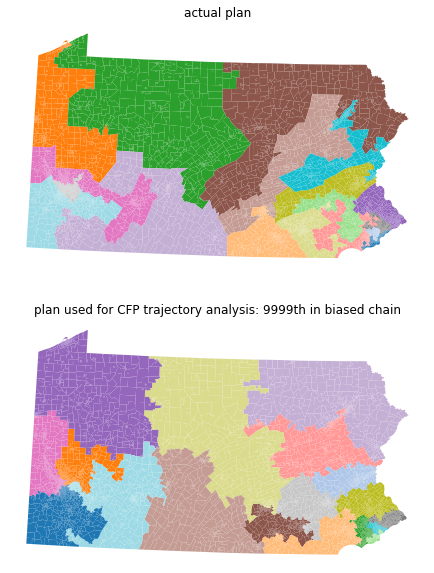

In [238]:
#identify a chain of interest
idx = len(all_assignments_PRES16R)-1
# import random
# idx = random.randrange(len(all_assignments))
test_partition = GeographicPartition(graph, all_assignments_PRES16R[idx], updaters=my_updaters)

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
plt.axis('off')
initial_partition.plot(cmap="tab20", ax=ax)
plt.title('actual plan')

ax = plt.subplot(2,1,2)
test_partition.plot(cmap="tab20", ax=ax)
plt.axis('off')
plt.title('plan used for CFP trajectory analysis: '+str(idx)+'th in biased chain' )
plt.xlabel(f)
#plt.show()

#### We want to create a few histograms for this biased ensemble. First we need to compute partisan metrics.

In [209]:
# from biased_accept import get_elec_results

In [239]:
## loops through all plans in biased ensemble favoring Republicans from the 2016 Pres election in PA, computes effiency gap, and stores these values in a list

efficiency_gaps_PRES16R = []

for partition in all_partitions_PRES16R:
    elec_result = get_elec_results(partition)
    efficiency_gaps_PRES16R.append(elec_result.efficiency_gap())

efficiency_gaps_PRES16R #check output

[0.14325094554670442,
 0.1443718029358129,
 0.14437180293581292,
 0.14437180293581292,
 0.14437180293581295,
 0.14437180293581292,
 0.14437180293581292,
 0.14437180293581292,
 0.14437180293581295,
 0.14437180293581295,
 0.1443718029358129,
 0.1431032861959231,
 0.1419840088758774,
 0.1419840088758774,
 0.14198400887587737,
 0.14198400887587742,
 0.14198400887587748,
 0.1411274208177619,
 0.1411274208177619,
 0.14112742081776192,
 0.14112742081776186,
 0.1411274208177619,
 0.14112742081776192,
 0.14112742081776186,
 0.14112742081776186,
 0.14112742081776194,
 0.1411274208177619,
 0.14112742081776192,
 0.14112742081776192,
 0.1411274208177619,
 0.1411274208177619,
 0.14112742081776197,
 0.14112742081776197,
 0.14112742081776197,
 0.19624931559605752,
 0.1962716117142128,
 0.1977267488276797,
 0.19772674882767963,
 0.1966217801183386,
 0.1966217801183386,
 0.1966217801183386,
 0.19662178011833853,
 0.19662178011833853,
 0.19662178011833853,
 0.19662178011833853,
 0.19662178011833853,
 0.1

In [240]:
data_eg_PRES16R = pd.DataFrame(efficiency_gaps_PRES16R) 

Text(0.5, 1.0, 'Efficiency Gap')

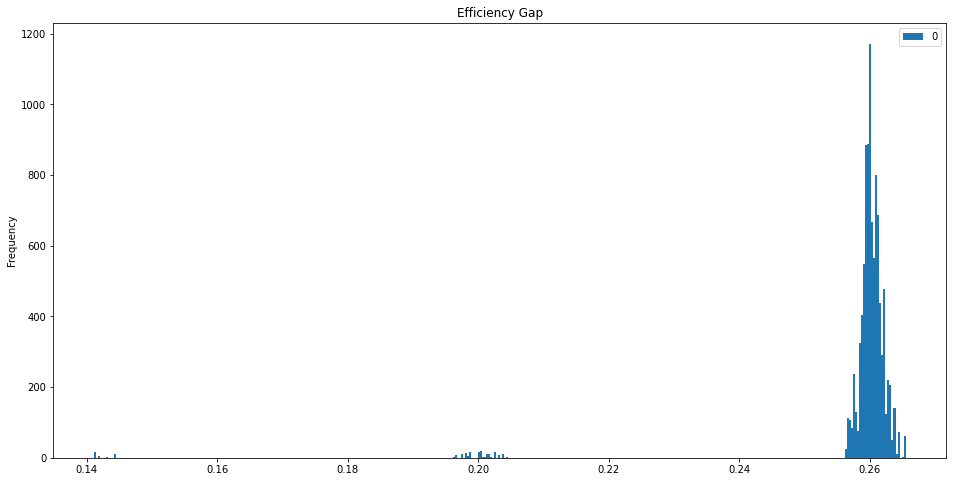

In [256]:
data_eg_PRES16R.plot.hist(bins=400, figsize=(16,8)).set_title("Efficiency Gap")

In [244]:
## loops through all plans in biased ensemble favoring Republicans from the 2016 Pres election in PA, 
## computes partisan metrics, and stores these values in a list

mean_median_PRES16R = []
partisan_bias_PRES16R = []
partisan_gini_PRES16R = []
mean_thirdian_PRES16R = []

for partition in all_partitions_PRES16R:
    elec_result = get_elec_results(partition)
    mean_median_PRES16R.append(elec_result.mean_median())
    partisan_bias_PRES16R.append(elec_result.partisan_bias())
    partisan_gini_PRES16R.append(elec_result.partisan_gini())
    mean_thirdian_PRES16R.append(elec_result.mean_thirdian())

In [249]:
## makes data frames for each metric

data_mm_PRES16R = pd.DataFrame(mean_median_PRES16R) 
data_pb_PRES16R = pd.DataFrame(partisan_bias_PRES16R) 
data_pg_PRES16R = pd.DataFrame(partisan_gini_PRES16R) 
data_mt_PRES16R = pd.DataFrame(mean_thirdian_PRES16R) 

## make data frame containing all partisan metrics

PRES16R_partisan_metrics = {"efficiency_gap": efficiency_gaps_PRES16R, 
                            "mean_median": mean_median_PRES16R,
                            "mean_thirdian": mean_thirdian_PRES16R, 
                            "partisan_bias": partisan_bias_PRES16R,
                            "partisan_gini": partisan_gini_PRES16R}

data_pm_PRES16R = pd.DataFrame.from_dict(PRES16R_partisan_metrics)

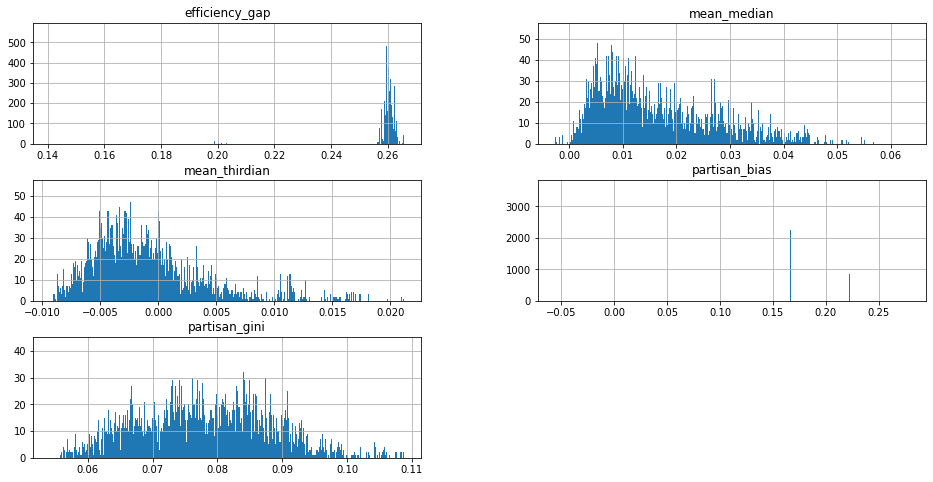

In [259]:
histograms = data_pm_PRES16R.hist(bins = 1000, figsize=(16,8))

In [248]:
## loops through all plans in biased ensemble favoring Republicans from the 2016 Pres election in PA, 
## computes percents, safe seats, party seats, and stores these values in a list

all_percents_PRES16R = [] # keep track of the democratic percentages
all_safe_seats_PRES16R = []
all_party_seats_PRES16R = []

for idx, partition in all_assignments_PRES16R:
    safe_seats = len([x for x in partition[election_name].percents(party_to_favor) if x > 0.53])
    all_safe_seats_PRES16R.append(safe_seats)

    all_percents_PRES16R.append(sorted(partition[election_name].percents(party_to_favor)))

    all_party_seats_PRES16R.append(elec_result.seats(party_to_favor))

ValueError: too many values to unpack (expected 2)

In [ ]:
## make dataframes for percents and seats

#data_percents = pd.DataFrame(all_percents) 
#data_percents = pd.DataFrame(all_safe_seats)
#data_percents = pd.DataFrame(partisan_metric_values)
#data_percents = pd.DataFrame(all_party_seats)

In [175]:
## how to find total population of each district in the partition

# for district, pop in test_partition["population"].items():
#    print("District {}: {}".format(district, pop))